In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
%matplotlib inline
import seaborn as sns

df_GDP= pd.read_excel("GDPC1.xls") #Importing Real GDP
df_BDS= pd.read_excel("Datamacro.xlsx", sheet_name=1) #Importing Business Dynamics Statistics (BDS)
df_BEA= pd.read_excel("Table.xlsx", header=4) #Importing Bureau of Economic Analysis (BEA)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<AxesSubplot:>

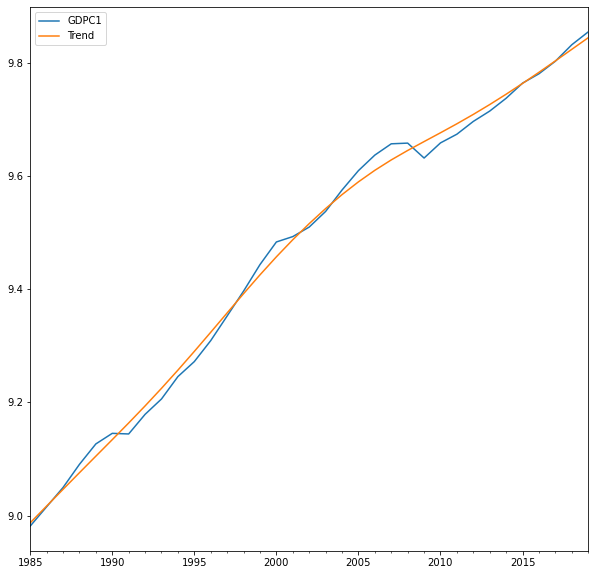

In [2]:
df_GDP['Year'] = df_GDP['observation_date'].dt.year #Convert dates to years
df_GDP=df_GDP.drop(["observation_date"], axis=1).dropna() #dropping na values

#Apply Ln

df_GDP["GDPC1"]=df_GDP["GDPC1"].apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019

df_GDP=df_GDP[df_GDP["Year"]>=1985]
df_GDP=df_GDP[df_GDP["Year"]<=2019]

#Apply HP Filter and plotting

index = pd.period_range(str(df_GDP.Year.iat[0]), str(df_GDP.Year.iat[-1]), freq='Y')
df_GDP.set_index(index, inplace=True)
cycle, trend= sm.tsa.filters.hpfilter(df_GDP["GDPC1"], 100)
df_GDP["Trend"]= trend
df_GDP["Cycle"]= cycle
df_GDP[["GDPC1", "Trend"]].plot(figsize=(10, 10))

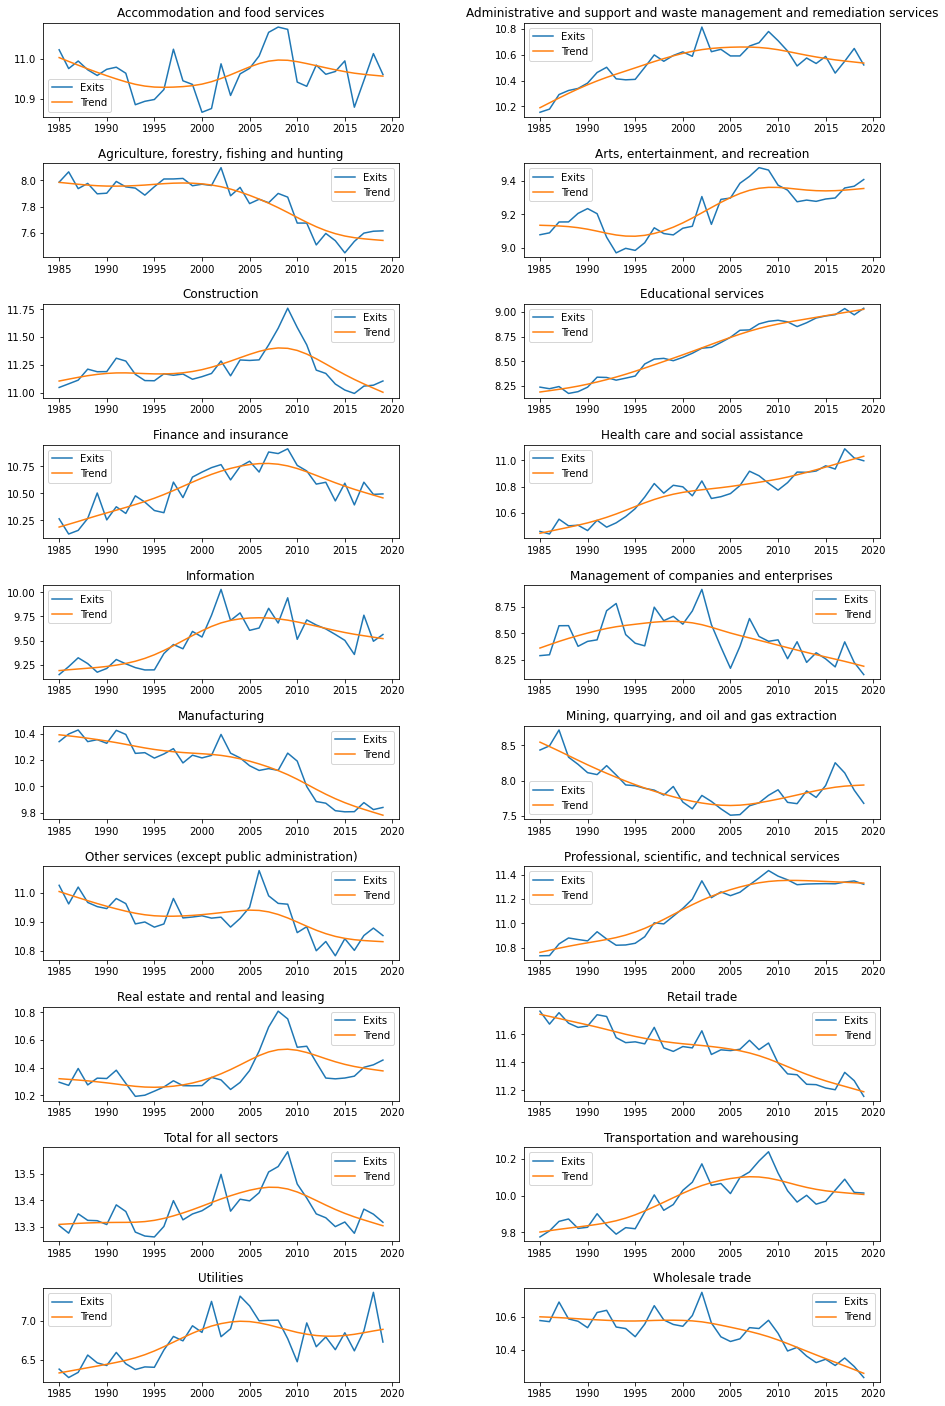

In [3]:
#Selecting rows of interest

df_BDS=(df_BDS[["Meaning of Establishment age code", "Year", "Number of establishments born during the last 12 months",
                "Number of establishments exited during the last 12 months",
                "Meaning of NAICS Code"]])

#Filtering Data

df_BDS= df_BDS[df_BDS['Meaning of Establishment age code']== "Total"]

#Convert Columns "Number of firms that exited during the last 12 months" to float type

df_BDS['Number of establishments exited during the last 12 months']= (df_BDS['Number of establishments exited during the last 12 months'].
                                                                   str.replace(",", ""))
df_BDS['Number of establishments exited during the last 12 months'] = (df_BDS['Number of establishments exited during the last 12 months'].
                                                                   astype(float))

#Convert Columns "Number of establishments exited during the last 12 months" to float type

df_BDS['Number of establishments born during the last 12 months']= (df_BDS['Number of establishments born during the last 12 months'].
                                                                   str.replace(",", ""))
df_BDS['Number of establishments born during the last 12 months'] = (df_BDS['Number of establishments born during the last 12 months'].
                                                                   astype(float))


#Convert Columns "Year" to int type

df_BDS['Year'] = df_BDS['Year'].astype(int)

df_BDS.reset_index(drop=True, inplace=True)

#Creating a dataframe with the dynamcics of exiting firms

df_exit=(
    df_BDS[["Meaning of NAICS Code", "Year", "Number of establishments exited during the last 12 months"]].
    pivot(index="Year",columns="Meaning of NAICS Code", values="Number of establishments exited during the last 12 months"))

#Apply Ln

df_exit=df_exit.apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019

df_exit=df_exit[df_exit.index>=1985]
df_exit=df_exit[df_exit.index<=2019]

#Apply HP Filter

for i in range (int(df_exit.shape[1])):
    cycle, trend=sm.tsa.filters.hpfilter(df_exit.iloc[:,i], 100)
    df_exit[str(i)+"Cycle"]=cycle
    df_exit[str(i)+"Trend"]=trend   

#Plotting

fig, axs = plt.subplots(10,2, figsize=(15,25))
fig.subplots_adjust(hspace = 0.5, wspace=.35)
axs = axs.ravel()
for i in range(20):
    axs[i].plot(df_exit.iloc[:,i])
    axs[i].plot(df_exit[str(i)+"Trend"])
    axs[i].set_title(str(df_exit.columns[i]))
    axs[i].legend(["Exits","Trend"]) 

<AxesSubplot:>

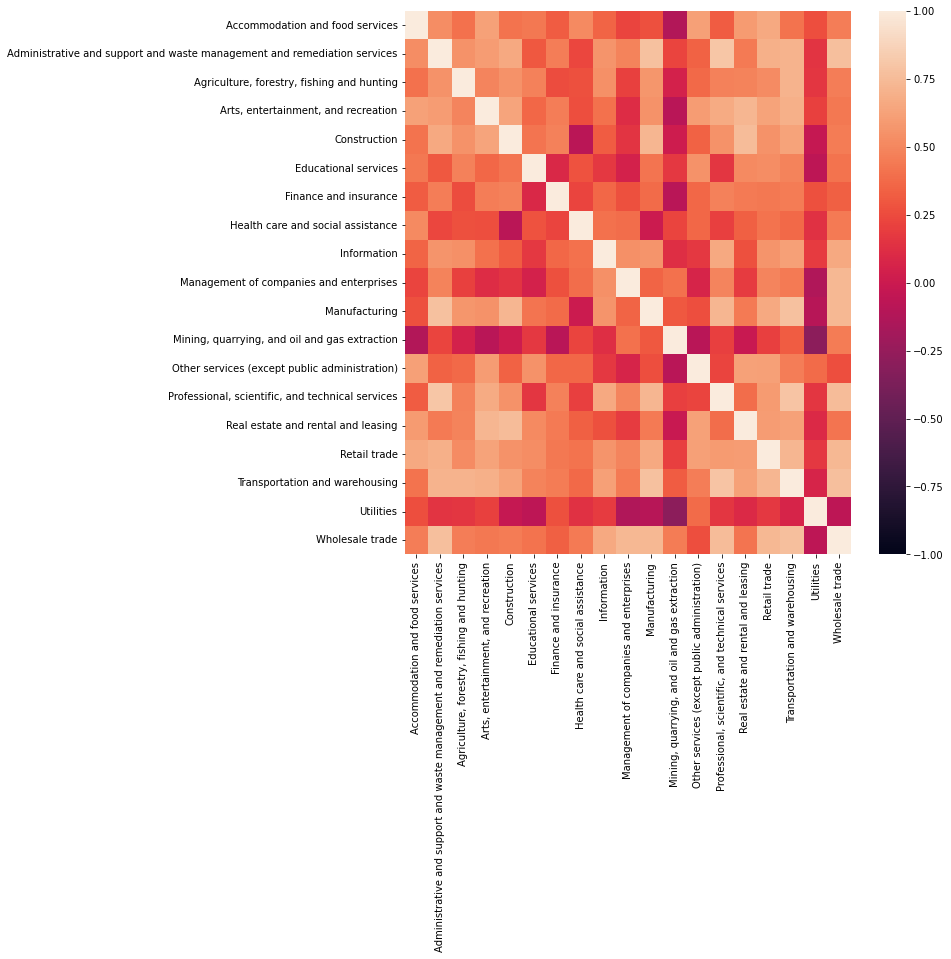

In [4]:
#Computing correlations between firms exit cycles


df_exit_corr=pd.DataFrame()

for i in range (20):
    df_exit_corr[i]=df_exit[[str(i)+"Cycle"]]
    df_exit_corr.rename(columns={i:df_exit.columns[i]}, inplace=True)
df_exit_corr=round(df_exit_corr.drop("Total for all sectors", axis=1).corr("pearson"),2)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_exit_corr, vmin=-1, vmax=1)

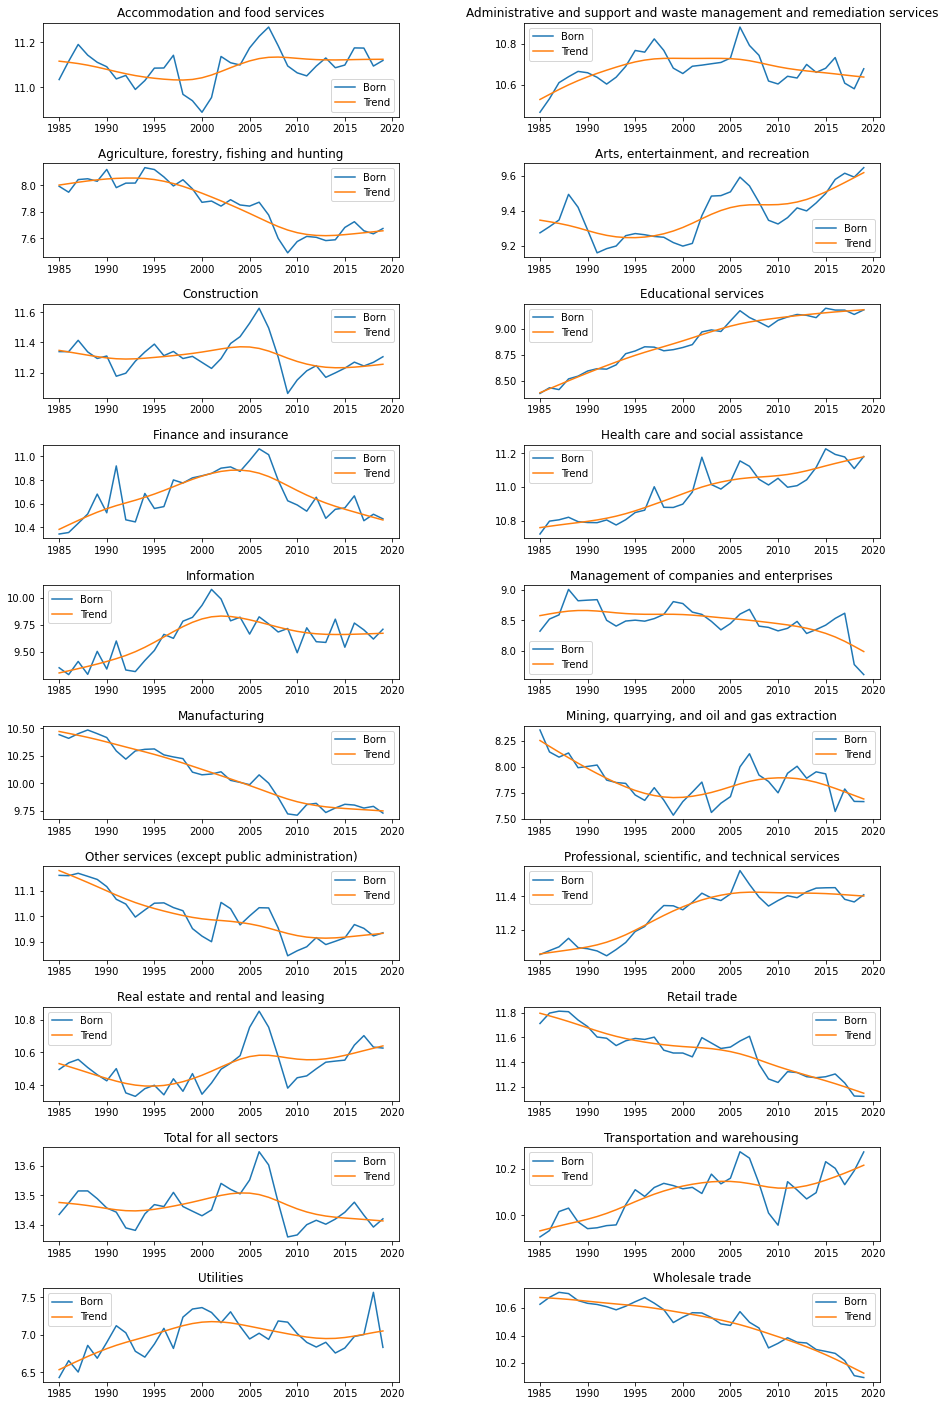

In [5]:
#Creating a dataframe with the dynamcics of born firms

df_entry=(
    df_BDS[["Meaning of NAICS Code", "Year", "Number of establishments born during the last 12 months"]])

df_entry=(df_entry.
          pivot(index="Year",columns="Meaning of NAICS Code", values="Number of establishments born during the last 12 months"))

#Apply Ln
df_entry=df_entry.apply(lambda x: np.log(x))

#Adjust Subsample of interest 1985/2019
df_entry=df_entry[df_entry.index>=1985]
df_entry=df_entry[df_entry.index<=2019]

#Apply HP Filter
for i in range (int(df_entry.shape[1])):
    cycle, trend=sm.tsa.filters.hpfilter(df_entry.iloc[:,i], 100)
    df_entry[str(i)+"Cycle"]=cycle
    df_entry[str(i)+"Trend"]=trend   

#Plotting
fig, axs = plt.subplots(10,2, figsize=(15,25))
fig.subplots_adjust(hspace = 0.5, wspace=.35)
axs = axs.ravel()
for i in range(20):
    axs[i].plot(df_entry.iloc[:,i])
    axs[i].plot(df_entry[str(i)+"Trend"])
    axs[i].set_title(str(df_entry.columns[i]))
    axs[i].legend(["Born","Trend"]) 

<AxesSubplot:>

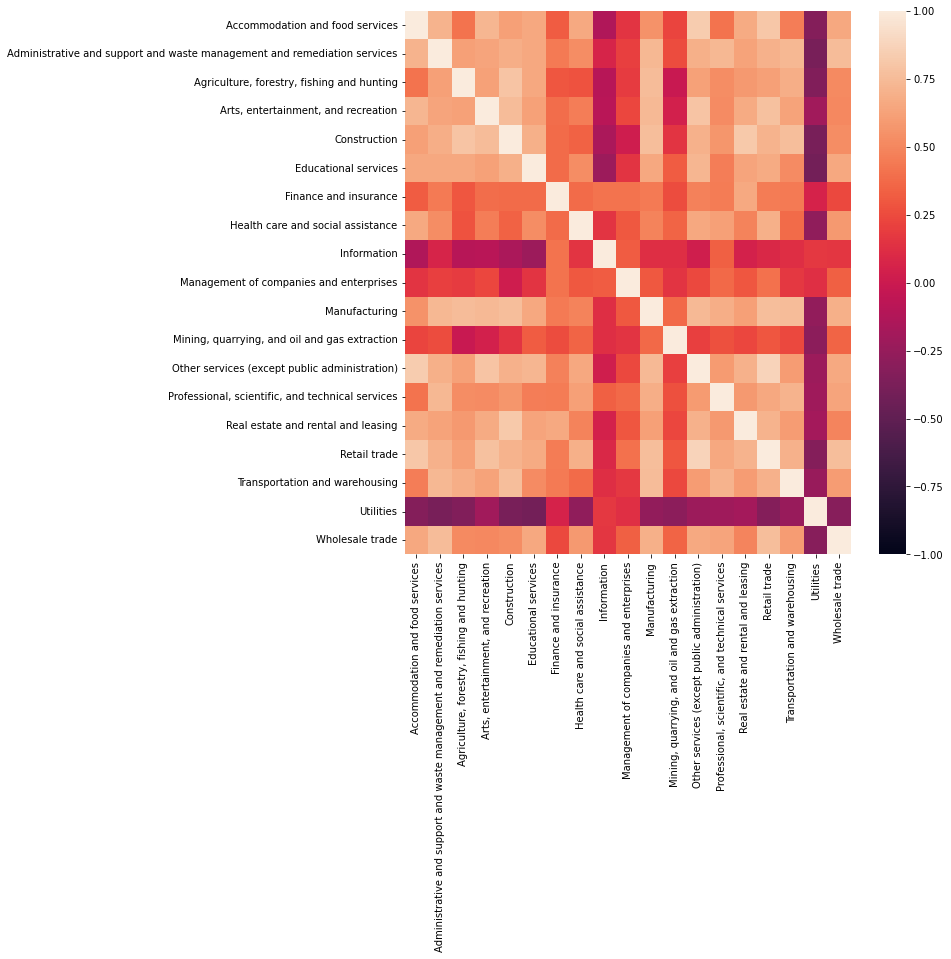

In [6]:
#Computing correlations between firms entries

df_entry_corr=pd.DataFrame()

for i in range (20):
    df_entry_corr[i]=df_entry[[str(i)+"Cycle"]]
    df_entry_corr.rename(columns={i:df_entry.columns[i]}, inplace=True)
df_entry_corr=round(df_entry_corr.drop("Total for all sectors", axis=1).corr("pearson"),2)
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_entry_corr, vmin=-1, vmax=1)

In [7]:
#Computing correlations between GDP Cycle and firm entries and exits cycles

df_corr=pd.DataFrame()
df_corr["GDP Cycle"]=df_GDP.set_index("Year").Cycle
df_corr["Exit Cycle"]=df_exit["16Cycle"]
df_corr["Entry Cycle"]=df_entry["16Cycle"]

round(df_corr.corr("pearson"),2)

,GDP Cycle,Exit Cycle,Entry Cycle
GDP Cycle,1.00,-0.05,0.56
Exit Cycle,-0.05,1.00,-0.09
Entry Cycle,0.56,-0.09,1.00


In [8]:
#Cleaning and filtering the data from BEA


df_BEA.drop(df_BEA.columns[0], axis=1)
df_BEA.columns = df_BEA.iloc[1]
df_BEA.drop(1, inplace=True)
df_BEA.drop(df_BEA.columns[0],axis=1,inplace=True)
df_BEA.rename(columns={"Name":"Commodities/Industries"}, inplace=True)
df_BEA.drop(0, inplace=True)
df_BEA.set_index("Commodities/Industries", inplace=True)
df_BEA=df_BEA.T
df_BEA=df_BEA.replace("---", 0)
df_BEA.drop(["Scrap, used and secondhand goods","Noncomparable imports and rest-of-the-world adjustment"],axis=1, inplace=True)
df_BEA.index=df_BEA.index.rename(None)

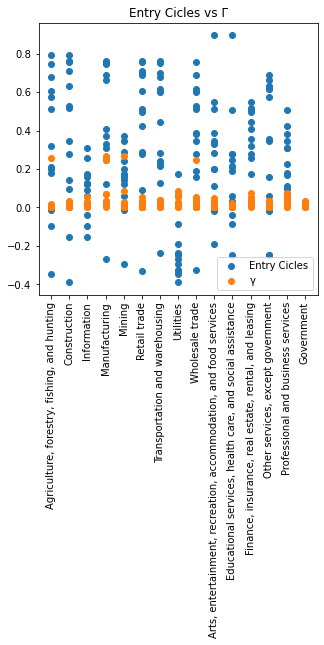

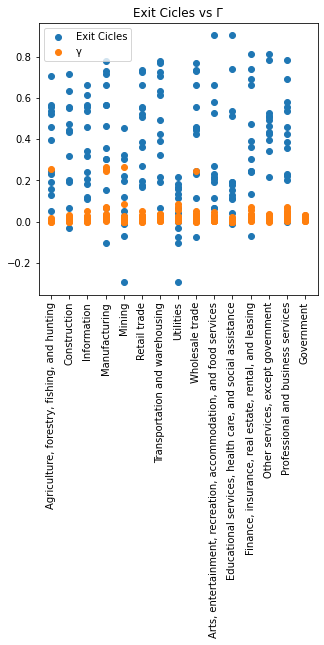

In [13]:
#Creating the Ratios of expenditures γ, Γ Matrix

ratios_expenditures=np.zeros((df_BEA.index.get_loc("Total Intermediate"),df_BEA.columns.get_loc("Total Intermediate")))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            ratios_expenditures[row,col]= df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col]
        if col<row:
            ratios_expenditures[row,col]=df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col]
        if col>row:
            ratios_expenditures[row,col]=df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.index.get_loc("Total use of products"),col]
df_ratios_expenditures= pd.DataFrame(ratios_expenditures, columns= df_BEA.columns[:df_BEA.columns.get_loc("Total Intermediate")])
df_ratios_expenditures=df_ratios_expenditures.apply(lambda x: round(x, 4)).set_index(df_BEA.index[:df_BEA.index.get_loc("Total Intermediate")])

#Creating the average Ratios of conectivity γ_hat Matrix

average_conectivity=np.zeros(df_ratios_expenditures.shape)
for col in range (df_ratios_expenditures.shape[1]):
    for row in range (df_ratios_expenditures.shape[0]):
        if col==row:
            average_conectivity[row,col]= None
        if col!=row:
            average_conectivity[row,col]= (df_ratios_expenditures.iloc[row,col]+df_ratios_expenditures.iloc[col,row])/2

df_average_conectivity= pd.DataFrame(average_conectivity, columns= df_ratios_expenditures.columns)
df_average_conectivity=df_average_conectivity.apply(lambda x: round(x, 4)).set_index(df_ratios_expenditures.index)

#Aggregating Data from BDS and matching it with BEA Data For entry

df_entry_corr=pd.DataFrame()

for i in range (20):
    df_entry_corr[i]=df_entry[[str(i)+"Cycle"]]
    df_entry_corr.rename(columns={i:df_entry.columns[i]}, inplace=True)

df_entry_corr["Arts, entertainment, recreation, accommodation, and food services"]=df_entry["Accommodation and food services"] + df_entry["Health care and social assistance"]
df_entry_corr["Educational services, health care, and social assistance"]=df_entry["Educational services"] + df_entry["Arts, entertainment, and recreation"]
df_entry_corr["Finance, insurance, real estate, rental, and leasing"]=df_entry["Finance and insurance"] + df_entry["Real estate and rental and leasing"]
df_entry_corr["Other services, except government"]=df_entry["Other services (except public administration)"] + df_entry["Administrative and support and waste management and remediation services"]
df_entry_corr["Professional and business services"]=df_entry["Professional, scientific, and technical services"] + df_entry["Management of companies and enterprises"]
df_entry_corr.drop(["Accommodation and food services", "Arts, entertainment, and recreation",
       "Health care and social assistance", "Educational services",
       "Real estate and rental and leasing", "Finance and insurance", 
       "Administrative and support and waste management and remediation services",
       "Other services (except public administration)",
      "Management of companies and enterprises", "Professional, scientific, and technical services","Total for all sectors"], axis=1, inplace=True)
df_entry_corr.rename(columns={"Mining, quarrying, and oil and gas extraction":"Mining","Agriculture, forestry, fishing and hunting": "Agriculture, forestry, fishing, and hunting"}, inplace=True)

#Creating Matrix Correlations for entry cycles

entry_corr=np.zeros((df_entry_corr.corr("pearson").shape))

for col in range (df_entry_corr.corr("pearson").shape[1]):
    for row in range (df_entry_corr.corr("pearson").shape[0]):
        if col==row:
            entry_corr[row,col]= None
        if col!=row:
            entry_corr[row,col]= df_entry_corr.corr("pearson").iloc[row,col]
            
df_entry_corr=pd.DataFrame(entry_corr, columns=df_entry_corr.columns)

#Aggregating Data from BDS and matching it with BEA Data For exit

df_exit_corr=pd.DataFrame()

for i in range (20):
    df_exit_corr[i]=df_exit[[str(i)+"Cycle"]]
    df_exit_corr.rename(columns={i:df_exit.columns[i]}, inplace=True)

df_exit_corr["Arts, entertainment, recreation, accommodation, and food services"]=df_exit["Accommodation and food services"] + df_exit["Health care and social assistance"]
df_exit_corr["Educational services, health care, and social assistance"]=df_exit["Educational services"] + df_exit["Arts, entertainment, and recreation"]
df_exit_corr["Finance, insurance, real estate, rental, and leasing"]=df_exit["Finance and insurance"] + df_exit["Real estate and rental and leasing"]
df_exit_corr["Other services, except government"]=df_exit["Other services (except public administration)"] + df_exit["Administrative and support and waste management and remediation services"]
df_exit_corr["Professional and business services"]=df_exit["Professional, scientific, and technical services"] + df_exit["Management of companies and enterprises"]
df_exit_corr.drop(["Accommodation and food services", "Arts, entertainment, and recreation",
       "Health care and social assistance", "Educational services",
       "Real estate and rental and leasing", "Finance and insurance", 
       "Administrative and support and waste management and remediation services",
       "Other services (except public administration)",
      "Management of companies and enterprises", "Professional, scientific, and technical services","Total for all sectors"], axis=1, inplace=True)
df_exit_corr.rename(columns={"Mining, quarrying, and oil and gas extraction":"Mining","Agriculture, forestry, fishing and hunting": "Agriculture, forestry, fishing, and hunting"}, inplace=True)

#Creating Matrix Correlations for exit cycles

exit_corr=np.zeros((df_exit_corr.corr("pearson").shape))

for col in range (df_exit_corr.corr("pearson").shape[1]):
    for row in range (df_exit_corr.corr("pearson").shape[0]):
        if col==row:
            exit_corr[row,col]= None
        if col!=row:
            exit_corr[row,col]= df_exit_corr.corr("pearson").iloc[row,col]
            
df_exit_corr=pd.DataFrame(exit_corr, columns=df_exit_corr.columns)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.melt().dropna().iloc[:,0]
y=df_entry_corr.melt().dropna().iloc[:,1]

plt.scatter(x,y)

x= df_average_conectivity.melt().dropna().iloc[:,0]
y=df_average_conectivity.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Entry Cicles vs Γ")
plt.legend(["Entry Cicles", "γ"])

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.melt().iloc[:,0]
y=df_exit_corr.melt().iloc[:,1]

plt.scatter(x,y)

x= df_average_conectivity.melt().dropna().iloc[:,0]
y=df_average_conectivity.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Exit Cicles vs Γ")
plt.legend(["Exit Cicles", "γ"])



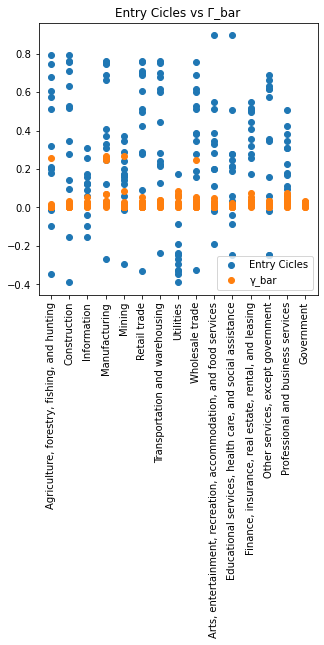

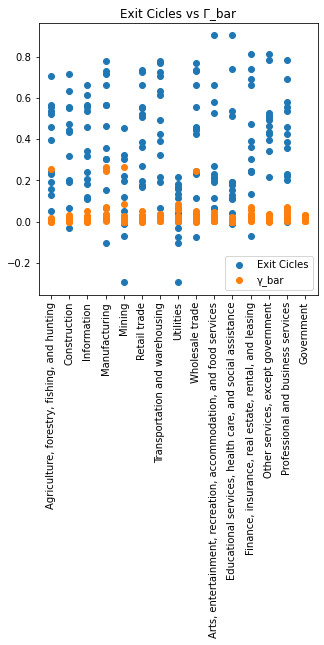

In [14]:
#Creating the Ratios of expenditures γ_bar, Γ_bar Matrix

ratios_expenditures_bar=np.zeros((df_BEA.index.get_loc("Total Intermediate"),df_BEA.columns.get_loc("Total Intermediate")))
for col in range (df_BEA.columns.get_loc("Total Intermediate")):
    for row in range (df_BEA.index.get_loc("Total Intermediate")):
        if col==row:
            ratios_expenditures_bar[row,col]= df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col]
        if col<row:
            ratios_expenditures_bar[row,col]=df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col]
        if col>row:
            ratios_expenditures_bar[row,col]=df_BEA.iloc[row,col]/df_BEA.iloc[df_BEA.columns.get_loc("Total industry output (basic prices)"),col]
df_ratios_expenditures_bar= pd.DataFrame(ratios_expenditures_bar, columns= df_BEA.columns[:df_BEA.columns.get_loc("Total Intermediate")])
df_ratios_expenditures_bar=df_ratios_expenditures_bar.apply(lambda x: round(x, 4)).set_index(df_BEA.index[:df_BEA.index.get_loc("Total Intermediate")])

#Creating the average Ratios of conectivity γ_bar Matrix

average_conectivity_bar=np.zeros(df_ratios_expenditures_bar.shape)
for col in range (df_ratios_expenditures_bar.shape[1]):
    for row in range (df_ratios_expenditures_bar.shape[0]):
        if col==row:
            average_conectivity_bar[row,col]= None
        if col!=row:
            average_conectivity_bar[row,col]= (df_ratios_expenditures_bar.iloc[row,col]+df_ratios_expenditures_bar.iloc[col,row])/2

df_average_conectivity_bar= pd.DataFrame(average_conectivity_bar, columns= df_ratios_expenditures_bar.columns)
df_average_conectivity_bar=df_average_conectivity_bar.apply(lambda x: round(x, 4)).set_index(df_ratios_expenditures_bar.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.melt().dropna().iloc[:,0]
y=df_entry_corr.melt().dropna().iloc[:,1]

plt.scatter(x,y)

x= df_average_conectivity_bar.melt().dropna().iloc[:,0]
y=df_average_conectivity_bar.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Entry Cicles vs Γ_bar")
plt.legend(["Entry Cicles", "γ_bar"])

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.melt().iloc[:,0]
y=df_exit_corr.melt().iloc[:,1]

plt.scatter(x,y)

x= df_average_conectivity.melt().dropna().iloc[:,0]
y=df_average_conectivity.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Exit Cicles vs Γ_bar")
plt.legend(["Exit Cicles", "γ_bar"])

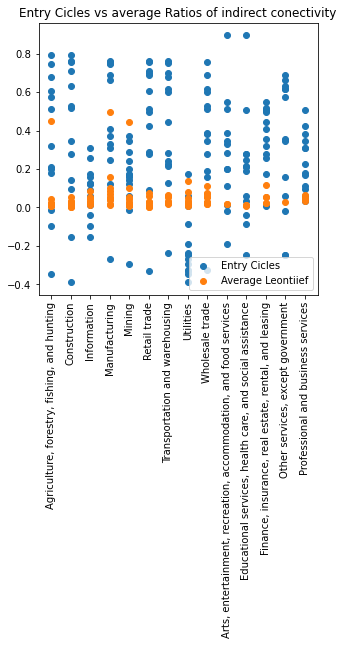

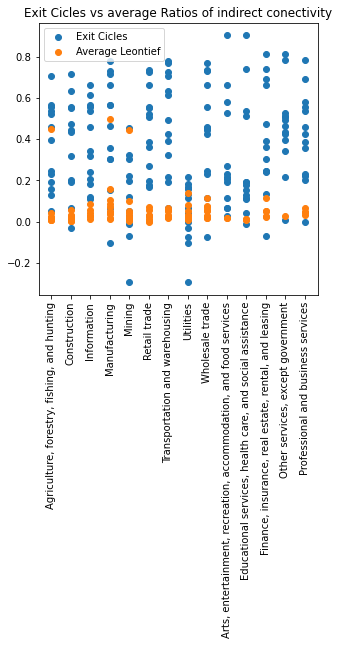

In [15]:
#Calculating Leontief Matrix

Leontief= (np.identity(df_ratios_expenditures.to_numpy().shape[0])-df_ratios_expenditures.to_numpy())
df_Leontief=pd.DataFrame(np.linalg.inv(Leontief),index=df_ratios_expenditures.index, columns=df_ratios_expenditures.columns)

#Calculating the average indirects conectivity in Leontief

average_Leontief=np.zeros(df_Leontief.shape)
for col in range (df_Leontief.shape[1]):
    for row in range (df_Leontief.shape[0]):
        if col==row:
            average_Leontief[row,col]= None
        if col<row:
            average_Leontief[row,col]= (df_Leontief.iloc[row,col]+df_Leontief.iloc[col,row])/2
        if col>row:
            average_Leontief[row,col]=None

df_average_Leontief= pd.DataFrame(average_Leontief, columns= df_Leontief.columns)
df_average_Leontief=df_average_Leontief.apply(lambda x: round(x, 4)).set_index(df_Leontief.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.melt().dropna().iloc[:,0]
y=df_entry_corr.melt().dropna().iloc[:,1]

plt.scatter(x,y)

x= df_average_Leontief.melt().dropna().iloc[:,0]
y=df_average_Leontief.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Entry Cicles vs average Ratios of indirect conectivity")
plt.legend(["Entry Cicles", "Average Leontiief"])

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.melt().iloc[:,0]
y=df_exit_corr.melt().iloc[:,1]

plt.scatter(x,y)

x= df_average_Leontief.melt().dropna().iloc[:,0]
y=df_average_Leontief.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Exit Cicles vs average Ratios of indirect conectivity")
plt.legend(["Exit Cicles", "Average Leontief"])



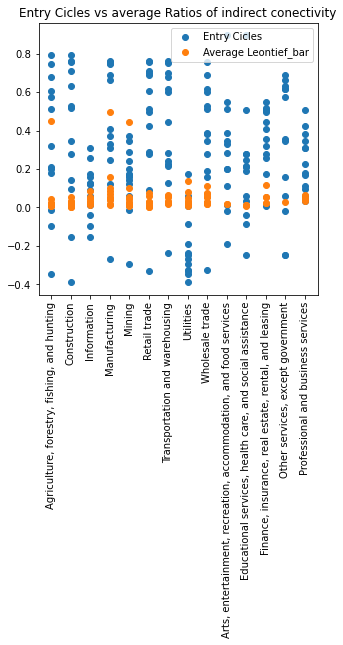

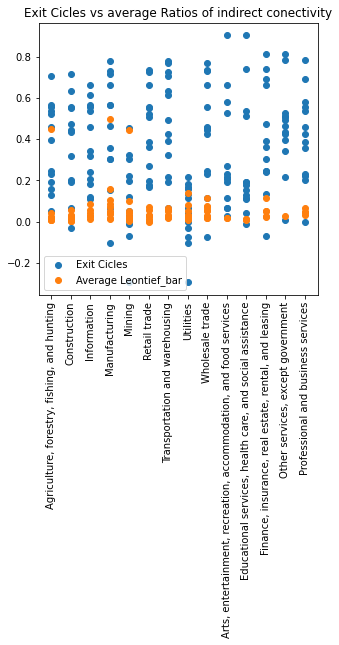

In [16]:
#Calculating Leontief_bar Matrix

Leontief_bar= (np.identity(df_ratios_expenditures_bar.to_numpy().shape[0])-df_ratios_expenditures_bar.to_numpy())
df_Leontief_bar=pd.DataFrame(np.linalg.inv(Leontief_bar),index=df_ratios_expenditures_bar.index, columns=df_ratios_expenditures_bar.columns)

#Calculating the average indirects conectivity in Leontief_bar

average_Leontief_bar=np.zeros(df_Leontief_bar.shape)
for col in range (df_Leontief_bar.shape[1]):
    for row in range (df_Leontief_bar.shape[0]):
        if col==row:
            average_Leontief_bar[row,col]= None
        if col<row:
            average_Leontief_bar[row,col]= (df_Leontief_bar.iloc[row,col]+df_Leontief_bar.iloc[col,row])/2
        if col>row:
            average_Leontief_bar[row,col]=None

df_average_Leontief_bar= pd.DataFrame(average_Leontief_bar, columns= df_Leontief_bar.columns)
df_average_Leontief_bar=df_average_Leontief_bar.apply(lambda x: round(x, 4)).set_index(df_Leontief_bar.index)

#Plotting Scatter plots

fig, axs = plt.subplots(figsize=(5,5))

x=df_entry_corr.melt().dropna().iloc[:,0]
y=df_entry_corr.melt().dropna().iloc[:,1]

plt.scatter(x,y)

x=df_average_Leontief_bar.melt().dropna().iloc[:,0]
y=df_average_Leontief_bar.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Entry Cicles vs average Ratios of indirect conectivity")
plt.legend(["Entry Cicles", "Average Leontief_bar"])

fig, axs = plt.subplots(figsize=(5,5))

x=df_exit_corr.melt().iloc[:,0]
y=df_exit_corr.melt().iloc[:,1]

plt.scatter(x,y)

x= df_average_Leontief.melt().dropna().iloc[:,0]
y=df_average_Leontief.melt().dropna().iloc[:,1]

plt.scatter(x,y)
plt.xticks(rotation = 90)
plt.title("Exit Cicles vs average Ratios of indirect conectivity")
plt.legend(["Exit Cicles", "Average Leontief_bar"])